In [1]:
from copy import deepcopy

In [2]:
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1, 1, 1, 1)
plt.rcParams['savefig.dpi'] = 300

Loading data

In [4]:
!wget -q https://raw.githubusercontent.com/EgorDudyrev/FCApy/main/data/liveinwater.cxt
K = FormalContext.read_cxt('liveinwater.cxt')
!rm liveinwater.cxt

Looking at the data

In [5]:
K

FormalContext (8 objects, 9 attributes, 34 connections)
           |needs water to live|lives in water|lives on land|needs chlorophyll|dicotyledon|monocotyledon|can move|has limbs|breast feeds|
fish leech |                  X|             X|             |                 |           |             |       X|         |            |
bream      |                  X|             X|             |                 |           |             |       X|        X|            |
frog       |                  X|             X|            X|                 |           |             |       X|        X|            |
dog        |                  X|              |            X|                 |           |             |       X|        X|           X|
water weeds|                  X|             X|             |                X|           |            X|        |         |            |
reed       |                  X|             X|            X|                X|           |            X|        |  

In [6]:
L = ConceptLattice.from_context(K)
len(L)

19

# Reprodusing the final result

Attributes that will be used for colouring

In [7]:
ms_color = ('lives in water', 'lives on land')

In [8]:
def node_clr_label_func(c_i, L, ms_color=ms_color):
    lbl = LineVizNx.concept_lattice_label_func(c_i, L, flg_new_extent_count_prefix=False, flg_new_intent_count_prefix=False)
    for s in ms_color:
        lbl = lbl.replace(s, '')
    lbl = lbl.replace(',', '')
    return lbl


L_clr = deepcopy(L)

# Drop a concept if it only describes the coloured attributes
for c in L_clr[1:]:    
    if set(c.intent)-set(ms_color) == set(L_clr.top_concept.intent):
        L_clr.remove(c)
    
# Drop a concept if it does not provide neither a new intent nor a new extent
# i.e. node label is empty
for c in L_clr[:-1]:
    if len(node_clr_label_func(L_clr.index(c), L_clr).strip()) == 0:
        L_clr.remove(c)    

Define the colours

In [9]:
clr_map = {frozenset(ms_color): 'khaki', frozenset({ms_color[0]}): 'navy', frozenset({ms_color[1]}): 'forestgreen',}
node_color_legend = {
    clr_map[frozenset(ms_color)]: 'lives on land and in water',
    clr_map[frozenset({ms_color[0]})]: 'lives in water',
    clr_map[frozenset({ms_color[1]})]: 'lives on land',
}

Attach each colour to each node. The default colour would be taken from the defaults of LineVizNx

In [10]:
viz = LineVizNx(node_label_font_size=14)

In [11]:
node_color = [clr_map.get(frozenset(c.intent)&frozenset(ms_color), viz.node_color) for c in L_clr]

Slightly modify the nodes positioning to make the figure look prettier

In [12]:
viz.init_mover_per_poset(L_clr)
mvr = viz.mover

mvr.place_node(1, (mvr.posx[3]+mvr.posx[4])/2)
mvr.place_node(9, mvr.posx[6])
for c_i in [2, 11]:
    mvr.place_node(c_i, (mvr.posx[5]+mvr.posx[12])/2)

Visulize everything

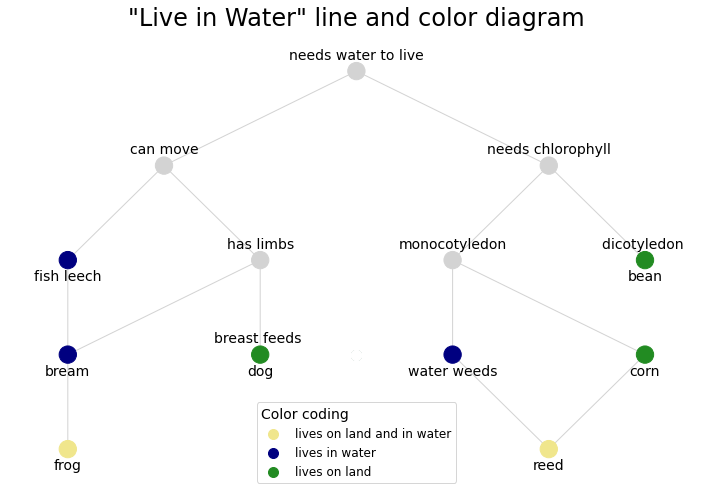

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

viz.draw_concept_lattice(
    L_clr, ax=ax,
    flg_drop_bottom_concept=True,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_clr_label_func,
)


leg = plt.legend(title='Color coding', title_fontproperties={'size': '14',}, fontsize=12, loc='lower center')
leg._legend_box.align = "left"

plt.title('"Live in Water" line and color diagram', size=24)
plt.tight_layout()
plt.savefig('imgs/live_in_water_lattice_color_short.png')
plt.show()

# Concept lattice visualization 

## Default visualization

Let us draw the first draft of a lattice

In [14]:
viz = LineVizNx()

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(11, 14): frozenset({9})}


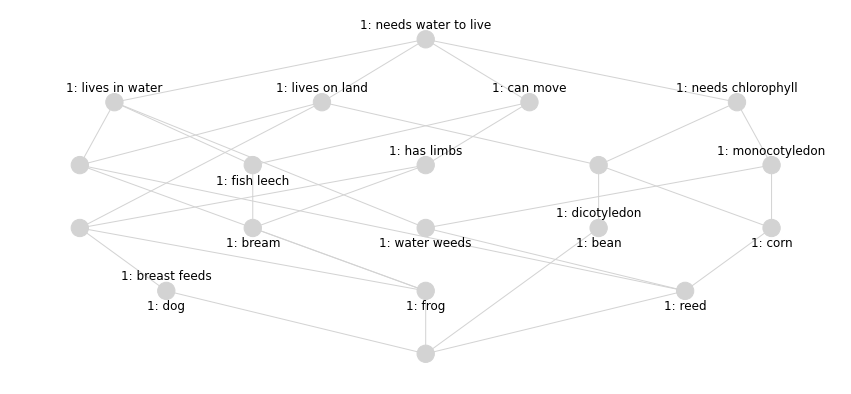

In [15]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(L, ax=ax,)
plt.show()

## Fix the nodes positioning

As the warning says, some edges overlap the nodes. Specifically, edge `(11, 14)` overlaps node `9`.

In order to find the erroneous place we
1. Toogle on `flg_node_indices` parameter to show node indices
2. Highlight edge `(11, 14)` with 'green' color
3. Highlight node `9` with 'pink' color

Please, modify the ``pos`` dictionary parameter manually. You can obtain the default ``pos`` via Mover.initialize_pos(...) function.

The problematic edges and nodes (in the form of {edge: overlapped nodes indexes}) are:
{(11, 14): frozenset({9})}


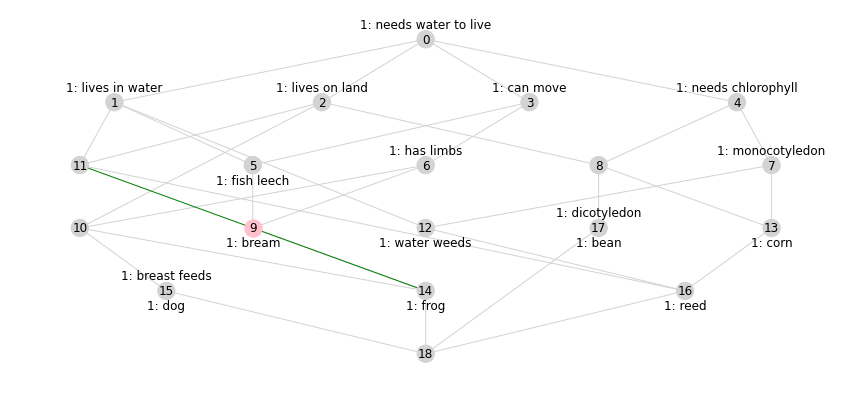

In [16]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_node_indices=True,
    edge_color=['green' if e==(11, 14) else viz.edge_color for e in  L.to_networkx().edges()],
    node_color=['pink' if v == 9 else viz.node_color for v in L.to_networkx().nodes()],
)
plt.show()

Let us move node `14` to the left, just under node `9` to fix the error.

In [17]:
viz.mover.place_node(14, viz.mover.posx[9])

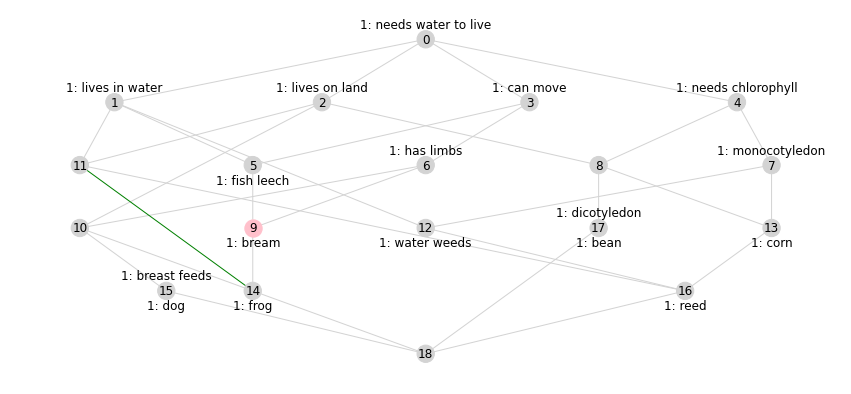

In [18]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_node_indices=True,
    edge_color=['green' if e==(11, 14) else viz.edge_color for e in  L.to_networkx().edges()],
    node_color=['pink' if v == 9 else viz.node_color for v in L.to_networkx().nodes()],
)
plt.show()

Success!

Now no edges overlap the nodes. But the lattice still does not look much pretty. Let us do something with it.

In addition, let us fix the current positioning for the future.

In [19]:
pos_fix = viz.mover.pos

## Manually adjust nodes positioning

In [20]:
viz.mover.pos = pos_fix

First, stop drawing intent and extent counts as the numbers are are really small.

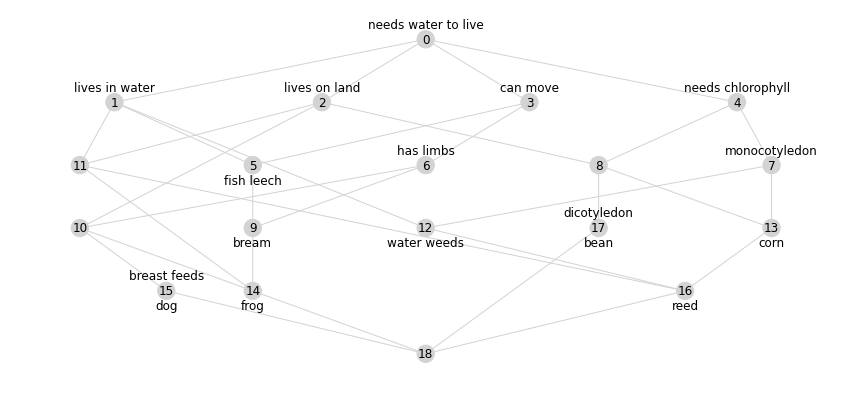

In [21]:
fig, ax = plt.subplots(figsize=(15,7))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_node_indices=True,
    flg_new_intent_count_prefix=False, flg_new_extent_count_prefix=False,
)
plt.show()

And now manually move the node positions.

Specifically, move "lives in water" and "lives on land" nodes closer to the center

In [22]:
viz.mover.pos = pos_fix

viz.mover.swap_nodes(1, 3)
viz.mover.swap_nodes(11, 6)
viz.mover.place_node(15, viz.mover.posx[10])

viz.mover.swap_nodes(1, 2)
viz.mover.swap_nodes(9, 10)

dx = (viz.mover.pos[11][0] - viz.mover.pos[14][0])/2
for node_i in [14, 15]:
    viz.mover.jitter_node(node_i, dx)

viz.mover.swap_nodes(8, 7)
viz.mover.swap_nodes(13, 17)
viz.mover.place_node(16, viz.mover.posx[2])

In [23]:
viz.node_label_font_size = 14

The following is somewhat pretty-looking concept lattice for 'Live in water' formal context.

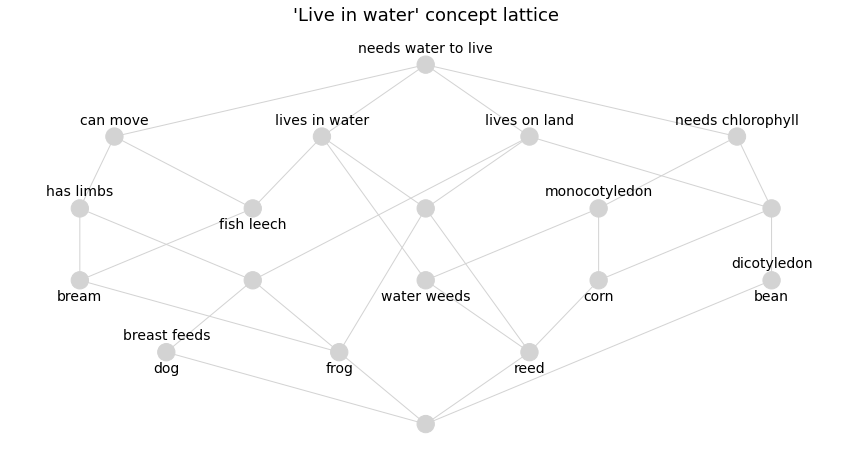

In [24]:
fig, ax = plt.subplots(figsize=(15,8))

viz.draw_concept_lattice(
    L, ax=ax,
    flg_new_intent_count_prefix=False,
    flg_new_extent_count_prefix=False,
    node_alpha=1
)
ax.set_title("'Live in water' concept lattice", size=18)

plt.show()

Formally, this is probably the best Concept Lattice visualization one can get.

But the figure still looks messy. Now, let us go beyond the formalities.

# Line and color diagram

## Add colors

Note that "can move" and "needs chlorophyll" are mutually exclusive. They represent animals and plants respectively.

So, the plan is:
1. Remove "lives ..." concepts from the diagram so that "can move" and "needs chlorophyll" form two nonoverlapping upper-semilattices.
2. Represent "lives ..." attributes with colors.
3. Slightly adjust the nodes positions

Removing unnecessary concepts

In [25]:
ms_color = ('lives in water', 'lives on land')

In [26]:
L_nolives = deepcopy(L)

# Drop the concepts that describe only the colourin
for c in L:
    if c==L.top_concept:
        continue
    
    if set(c.intent)-set(ms_color)==set(L_nolives.top_concept.intent):
        L_nolives.remove(c)

Move "lives ..." attributes from node labels to node colors.

In [27]:
def node_clr_label_func(c_i, L, ms_color=ms_color):
    lbl = LineVizNx.concept_lattice_label_func(c_i, L, flg_new_extent_count_prefix=False, flg_new_intent_count_prefix=False)
    for s in ms_color:
        lbl = lbl.replace(s, '')
    lbl = lbl.replace(',', '')
    return lbl


clr_map = {frozenset(ms_color): 'khaki', frozenset({ms_color[0]}): 'navy', frozenset({ms_color[1]}): 'forestgreen',}
node_color_legend = {
    clr_map[frozenset(ms_color)]: 'lives on land and in water',
    clr_map[frozenset({ms_color[0]})]: 'lives in water',
    clr_map[frozenset({ms_color[1]})]: 'lives on land',
}

In [28]:
viz = LineVizNx(node_label_font_size=14)

In [29]:
node_color = [clr_map.get(frozenset(c.intent)&frozenset(ms_color), viz.node_color) for c in L_nolives]

Slightly adjust the nodes positions.

In [30]:
viz.init_mover_per_poset(L_nolives)
viz.mover.place_node(1, (viz.mover.posx[3]+viz.mover.posx[4])/2)
for c_i in [7, 11]:
    viz.mover.place_node(c_i, viz.mover.posx[3])
for c_i in [8, 12]:
    viz.mover.place_node(c_i, viz.mover.posx[4])
for c_i in [9, 10, 14]:
    viz.mover.jitter_node(c_i, viz.mover.posx[0] - viz.mover.posx[8])
for c_i in [2, 10, 13]:
    viz.mover.place_node(c_i, (viz.mover.posx[5]+viz.mover.posx[6])/2)

viz.mover.place_node(14, viz.mover.posx[6])

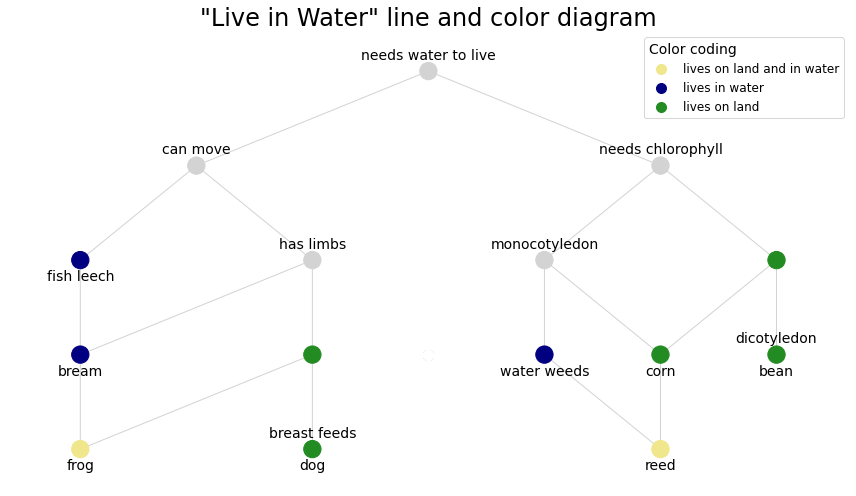

In [31]:
fig, ax = plt.subplots(figsize=(12,7))

viz.draw_concept_lattice(
    L_nolives, ax=ax,
    flg_drop_bottom_concept=True,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_clr_label_func,
)


leg = plt.legend(title='Color coding', title_fontproperties={'size': '14',}, fontsize=12, loc='upper right')
leg._legend_box.align = "left"

plt.title('"Live in Water" line and color diagram', size=24)
plt.tight_layout()
plt.savefig('imgs/live_in_water_lattice_color.png')
plt.show()

Figure looks better now. However, there are nodes with no labels. They might be skipped too.

## Remove the nodes that have no new intent or extent

In [32]:
L_nolives2 = deepcopy(L_nolives)

# Drop the nodes that have empty label
for c_i, c in enumerate(L_nolives):
    if c == L_nolives2.bottom_concept:
        continue
    
    if len(node_clr_label_func(c_i, L_nolives).strip()) == 0:
        L_nolives2.remove(c)

In [33]:
viz.init_mover_per_poset(L_nolives2)
viz.mover.place_node(1, (viz.mover.posx[3]+viz.mover.posx[4])/2)
viz.mover.place_node(9, viz.mover.posx[6])
for c_i in [2, 11]:
    viz.mover.place_node(c_i, (viz.mover.posx[5]+viz.mover.posx[12])/2)

In [34]:
node_color = [clr_map.get(frozenset(c.intent)&frozenset(ms_color), viz.node_color) for c in L_nolives2]

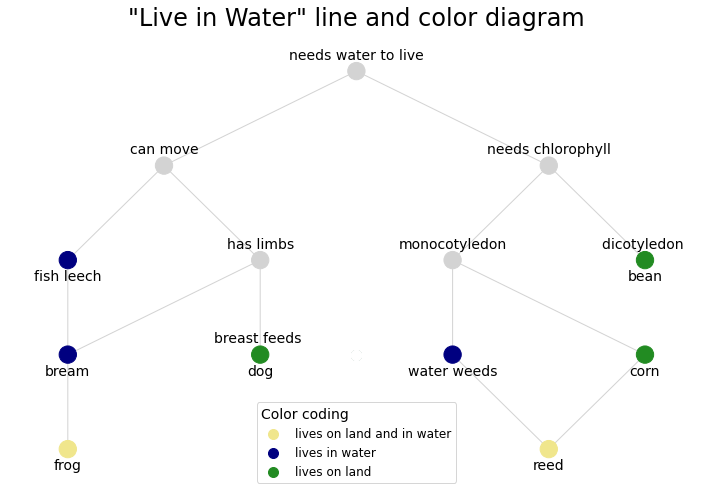

In [35]:
fig, ax = plt.subplots(figsize=(10, 7))

viz.draw_concept_lattice(
    L_nolives2, ax=ax,
    flg_drop_bottom_concept=True,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_clr_label_func,
)


leg = plt.legend(title='Color coding', title_fontproperties={'size': '14',}, fontsize=12, loc='lower center')
leg._legend_box.align = "left"

plt.title('"Live in Water" line and color diagram', size=24)
plt.tight_layout()
plt.savefig('imgs/live_in_water_lattice_color_short.png')
plt.show()

# In conclusion

In [36]:
import seaborn as sns

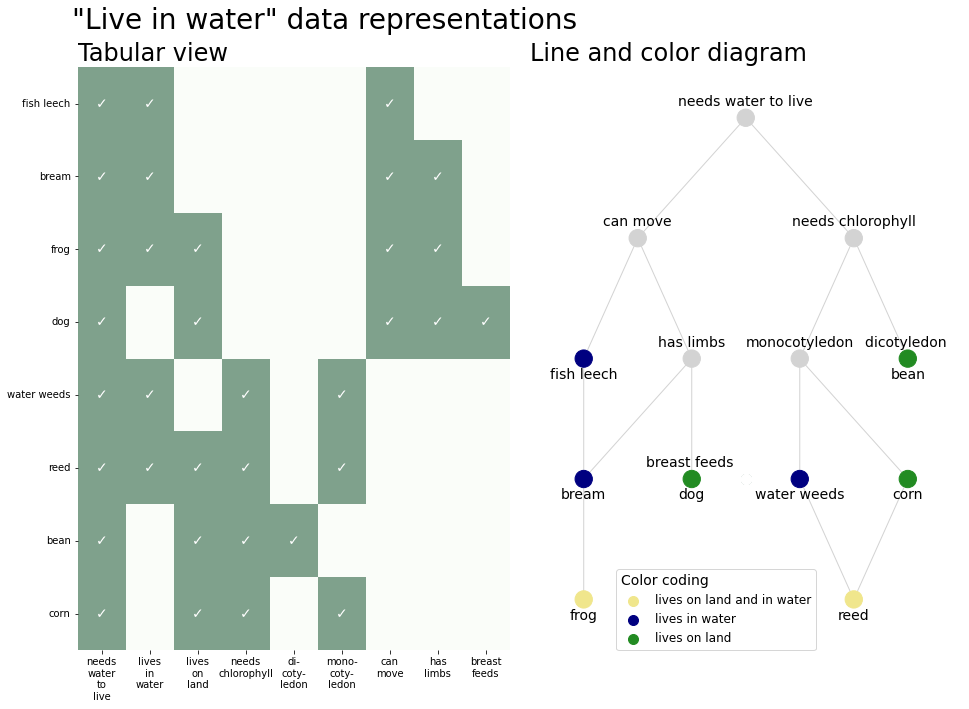

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

ax = axs[0]
sns.heatmap(
    K.to_pandas(), cmap='Greens', alpha=0.5, ax=ax, cbar=False,
    annot=K.to_pandas().replace(True, '✓').replace(False, ''), fmt='', annot_kws={'fontsize': 14},
)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels([
    lbl.get_text().replace(' ', '\n') if 'cotyledon' not in lbl.get_text()
    else lbl.get_text().replace('cotyledon', '-\ncoty-\nledon')
    for lbl in ax.get_xticklabels()
], rotation=0)
ax.set_title('Tabular view', size=24, ha='left', x=0.00)



ax = axs[1]

viz.draw_concept_lattice(
    L_nolives2, ax=ax,
    flg_drop_bottom_concept=True,
    node_color=node_color,
    node_color_legend=node_color_legend,
    node_label_func=node_clr_label_func,
)


leg = plt.legend(title='Color coding', title_fontproperties={'size': '14',}, fontsize=12, loc=(0.2,0))#'lower center')
leg._legend_box.align = "left"

#plt.title('"Live in Water" line and color diagram', size=24)

ax.set_title('Line and color diagram', size=24, ha='left', x=0.0)
ax.set_xlim(-0.8, 0.8)

plt.suptitle('"Live in water" data representations', size=28, ha='left', x=0.07)

plt.subplots_adjust(wspace=5, top=0.25)
plt.tight_layout()
plt.savefig('imgs/live_in_water_representation_comparison.png')
plt.show()